# Ensemble Learning

## 實際操作

### **Part 1 隨機森林分類實作：糖尿病罹患預測**

使用一個醫療研究用的糖尿病資料集，包含病人的多個生理特徵、是否罹患糖尿病。  
資料集源自美國國家糖尿病和消化和腎臟疾病研究所，資料來源：https://www.kaggle.com/datasets/mathchi/diabetes-data-set

總共有768筆資料，每筆資料都包含8個研究人員在糖尿病診斷中認為最具影響力的因素的資訊，包含懷孕次數、血糖濃度、血壓、皮膚厚度、胰島素水平、身體質量指數、家族糖尿病史、年齡，和是否有糖尿病的標籤

輸入特徵：
- Pregnacies：懷孕次數
- Glucose：糖耐量測試後2小時的血漿葡萄糖濃度
- BloodPressure：舒張壓（mm Hg），用於衡量心臟收縮時的壓力
- SkinThickneww：三頭肌皮膚褶皺厚度（mm），反映皮膚脂肪層厚度
- Insulin：2小時血清胰島素水平（mm U/ml）
- BMI：身體質量指數，用於評估體重狀況
- DiabetesPedigreeFunction：糖尿病家族遺傳函數，用於評估家族遺傳風險
- Age：病人年齡

輸出：
- Outcome：病人是否有糖尿病，0表示未罹患；1表示患有糖尿病

我們的目標是建立一個分類模型以預測病人是否罹患糖尿病，並藉由實作探討決策樹的多寡對隨機森林的影響

In [5]:
#1 載入資料集
import pandas as pd

df_data = pd.read_csv('./dataset/diabetes/diabetes.csv')
df_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 資料視覺化

先繪製各個輸出類別和特徵的統計分布，觀察資料

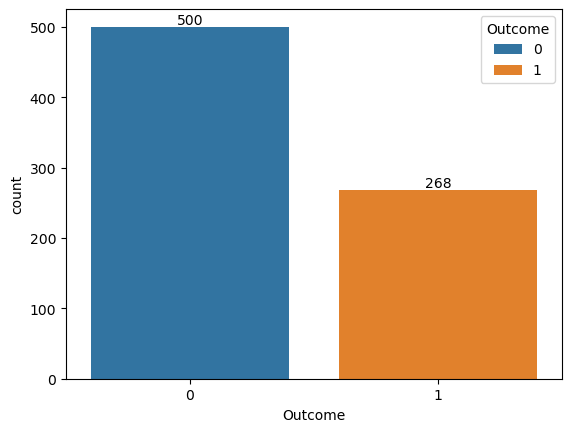

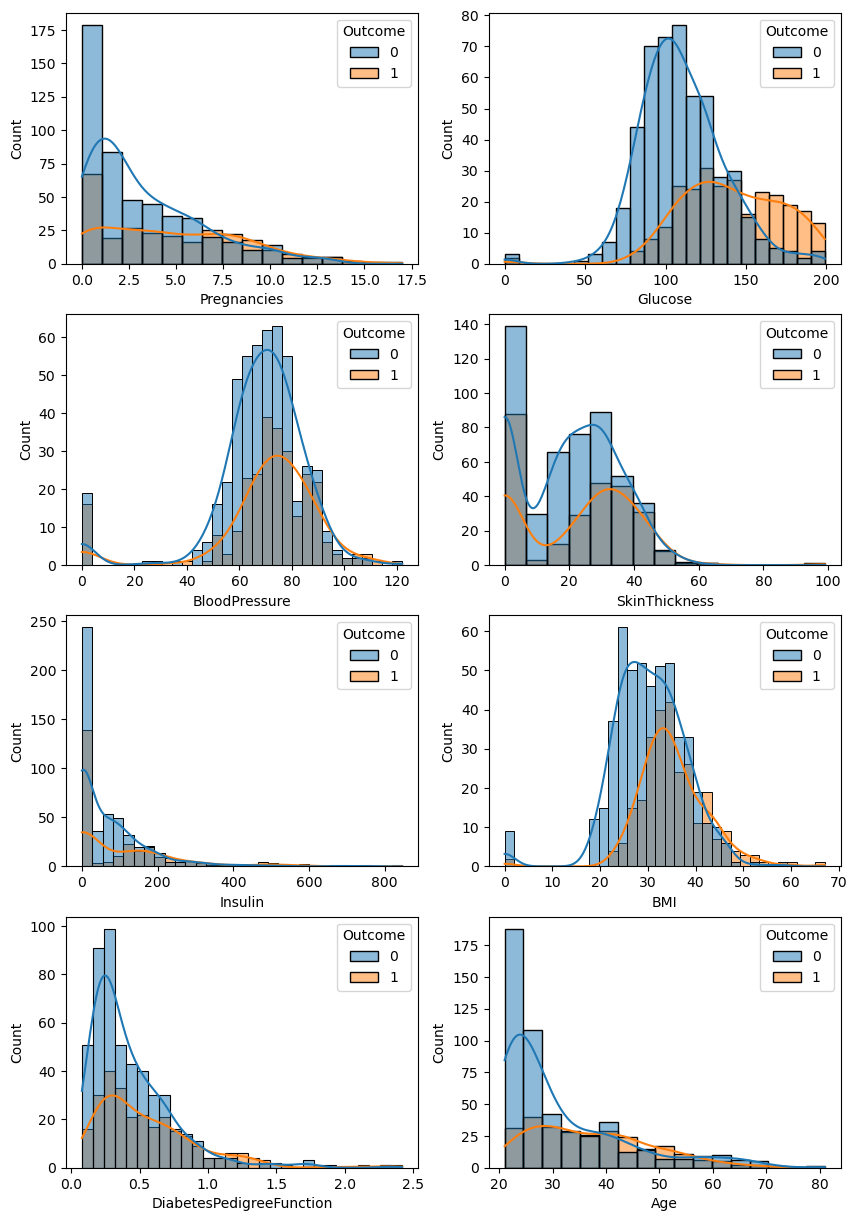

In [9]:
#2 觀察資料集的統計分布
import matplotlib.pyplot as plt
import seaborn as sns

x_feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# 統計輸出類別的數量
ax = sns.countplot(data=df_data, x='Outcome', hue='Outcome', palette='tab10')
for container in ax.containers:
    ax.bar_label(container)

# 統計各特徵的數據分布
fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for ax, name in zip(axes.flatten(), x_feature_names):
    sns.histplot(data=df_data, x=name, hue="Outcome", kde=True, palette="tab10", ax=ax)

結果可以發現：
- 類別0是1的兩倍
- 在Glucose、BloodPressure、SkinThickness、Insulin和BMI中有分布詭異的0數據
- 雖然我不是醫療領域的專家，但這些值理論上不該是0，所以要針對這些資料進行異常值的修正

### 資料前處理

這邊先把異常值抓出來，然後用平均數取代它們

In [14]:
#3 資料前處理 - 計算異常值的數量
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 計算特徵值為0的佔比
for feature in zero_features:
    zero_count = df_data[df_data[feature] == 0][feature].count()
    total_count = len(df_data[feature])
    percentage = round(100 * zero_count / total_count, 2)
    print(f'{feature} 特徵的數值有{zero_count}筆為零，佔比為{percentage}%')

Glucose 特徵的數值有5筆為零，佔比為0.65%
BloodPressure 特徵的數值有35筆為零，佔比為4.56%
SkinThickness 特徵的數值有227筆為零，佔比為29.56%
Insulin 特徵的數值有374筆為零，佔比為48.7%
BMI 特徵的數值有11筆為零，佔比為1.43%


In [16]:
#4 資料前處理 - 用平均數取代異常值
zero_features_mean = df_data[zero_features].mean()

df_data[zero_features] = df_data[zero_features].replace(0, zero_features_mean)

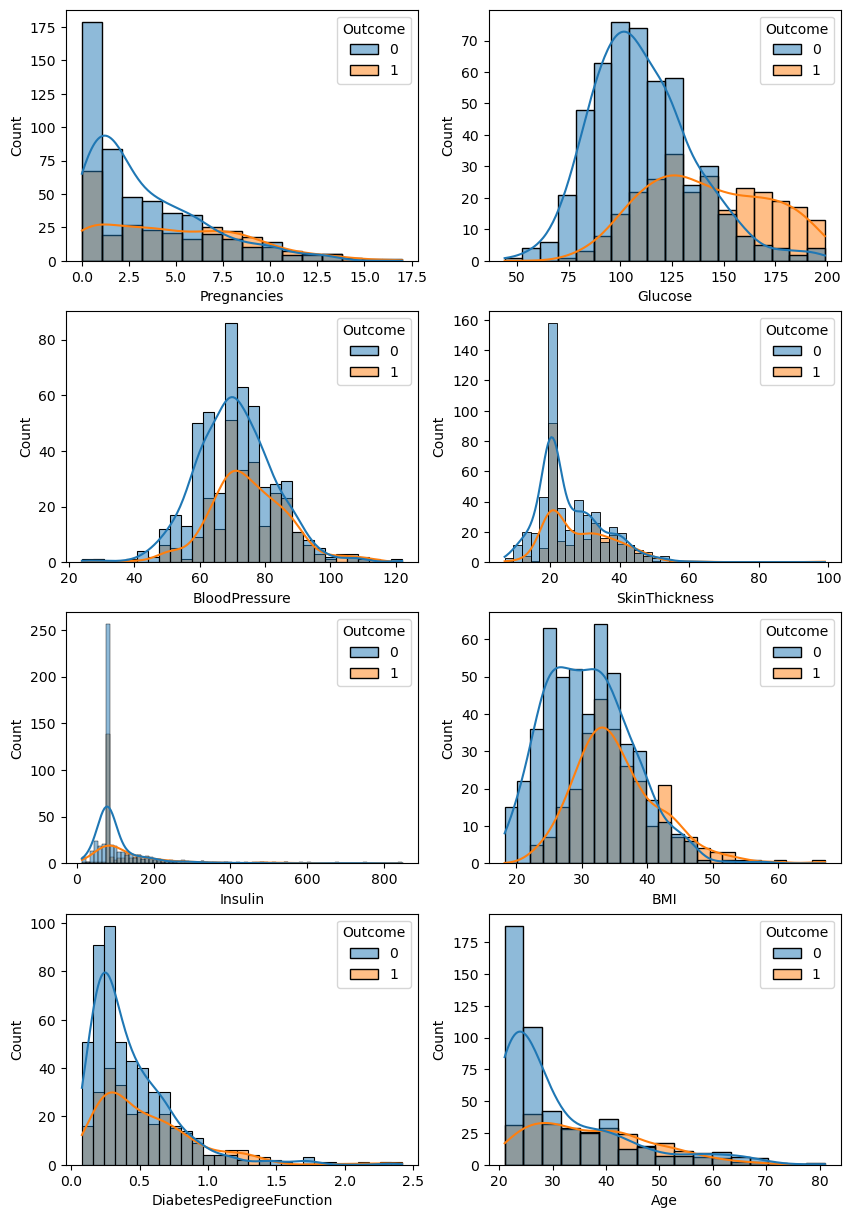

In [18]:
#5 觀察修正後的資料集統計分布
# 繪製直方圖
fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for ax, name in zip(axes.flatten(), x_feature_names):
    sns.histplot(data=df_data, x=name, hue="Outcome", kde=True, palette="tab10", ax=ax)

結果可以發現：
- 已經成功修正異常值了
- Glucose、BMI和Age的兩種顏色的線（數據分布）差異最明顯，應該是重要的分辨因子  

### 分割資料集

將資料分割成測試3訓練7

In [23]:
#6 分割資料
from sklearn.model_selection import train_test_split

# 從資料及中分離出y
X = df_data.drop(['Outcome'], axis=1).values
y = df_data['Outcome'].values

# 以測試1訓練9分割資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('Shape of training set X:', X_train.shape)
print('Shape of testing set X:', X_test.shape)

Shape of training set X: (537, 8)
Shape of testing set X: (231, 8)


### 建立並訓練模型

使用貝氏超參數微調，並建立Randomforest模型

In [48]:
#7 建立隨機森林分類模型
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# 先設定class_weight='balanced'
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# 定義超參數空間
search_spaces = {'n_estimators': Integer(50, 300),
                 'max_depth': Integer(3, 20),
                 'min_samples_split': Integer(2, 20),
                 'min_samples_leaf': Integer(1, 10),
                 'max_features': Categorical(['sqrt', 'log2', None]),
                 'class_weight': Categorical(['balanced', None])}

# 定義BayesSearchCV
opt = BayesSearchCV(estimator=rf_model,
                    search_spaces=search_spaces,
                    scoring='accuracy',
                    cv=5,
                    n_iter=20,
                    n_jobs=-1,
                    verbose=1,
                    random_state=42)

# 超參數搜尋與訓練模型
opt.fit(X_train, y_train)

# 用模型預測
y_pred = opt.best_estimator_.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

### 評估訓練結果

用準確度數據及混淆矩陣來觀察模型的訓練狀況

In [50]:
#8 評估訓練結果
from sklearn.metrics import classification_report, accuracy_score

print("Best parameters:", opt.best_params_)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best parameters: OrderedDict({'class_weight': None, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 11, 'n_estimators': 74})
Test accuracy: 0.7359307359307359

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81       150
           1       0.66      0.52      0.58        81

    accuracy                           0.74       231
   macro avg       0.71      0.69      0.69       231
weighted avg       0.73      0.74      0.73       231



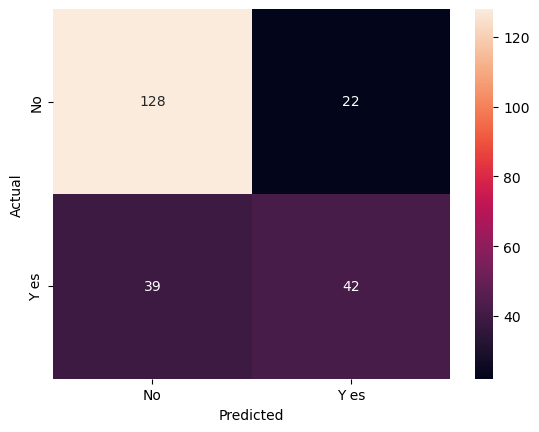

In [61]:
#9 進一步觀察結果的混淆矩陣
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(actual_val, pred_val, labels, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val, rownames=['Actual'], colnames=['Predicted'])
    plot = sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt=',.0f')

    if title is None:
        pass
    else:
        plot.set_title(title)

    plt.show

plot_confusion_matrix(y_test, y_pred, labels=['No', 'Y es'])

結果可以發現：
- `class_weight='balanced'`能解決的問題還是很有限，class 1的準確度仍然較差
- 由於0的樣本數太多了，所以模型傾向預測0
- 選出的參數有防止過擬合，結構比較淺，有助於泛化（代價就是recall較低）

C:\Users\USER\AppData\Local\Temp\ipykernel_95856\1873354715.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(x_feature_names)[indices], palette='viridis')


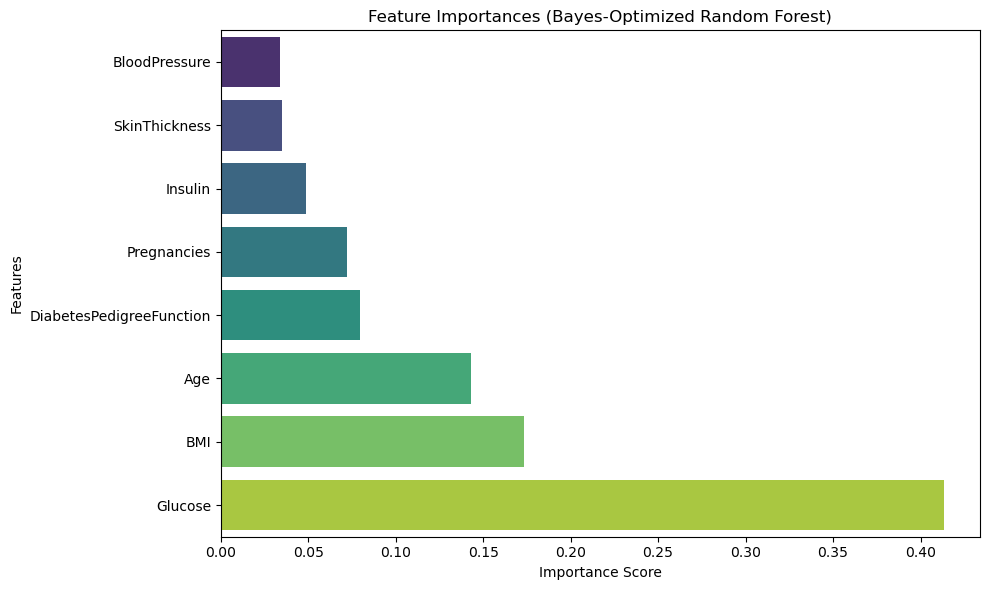

In [65]:
#10 觀察特徵重要性
import numpy as np

# 取得特徵重要性
best_model = opt.best_estimator_
importances = best_model.feature_importances_
indices = np.argsort(importances)

# 繪製橫向長條圖
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(x_feature_names)[indices], palette='viridis')
plt.title("Feature Importances (Bayes-Optimized Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

結果可以發現：
- Glucose、BMI和Age的重要性最高，呼應前面的統計圖表觀察結果  

### **Part 2 隨機森林迴歸實作：帕金森氏症評估預測**

接著練習如何使用隨機森林迴歸器預測帕金森氏症患者的運動和總UPDRS分數，這些患者參與了一項為期6個月的遠端疾病監測設備試驗，紀錄相關數據    

UPDRS（Unified Parkinson's Disease Rating Scale）是一種評估帕金森氏症病情的指標，包括motor UPDRS和total UPDRS  
 - motor UPDRS：評估患者的運動功能  
 - total UPDRS：考慮運動以外的症狀，Ex.: 情緒、認知等  
   
資料來源：https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring  

總共有5875筆資料，每筆資料都包含42個患者的相關資訊及量測的聲音訊號特徵，目標是根據這些資訊來預測UPDRS評估分數  

輸入特徵：  
- subject：編號
- age：年齡
- sex：性別，0是男生1是女生（好欸不用編碼）
- test_time：自加入試驗開始經過的時間，整數部分即為天數
- Jitter(%), Jitter(Abs), Jitter:RAP, Jitter:PPQ5, Jitter:DDP：訊號中基本頻率變化的幾個衡量指標
- Shimmer, Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, Shimmer:APQ11, Shimmer:DDA：訊號中振幅變化的幾個衡量指標
- NHR, HNR：聲音中噪音和音調成分的比值
- RPDE：非線性動態複雜度測量
- DFA：訊號分型標度指數
- PPE：非線性的基頻變化量測

輸出：
- motor_UPDRS：臨床醫師評估的運動UPDRS分數
- total_UPDRS：臨床醫師評估的總UPDRS分數

In [69]:
#1 載入資料集
import pandas as pd

df_data = pd.read_csv('./dataset/parkinsons_telemonitoring/parkinsons_updrs.data')

df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

### 資料視覺化

分別觀察看看不同性別的比例、不同年齡層的分布狀況和輸出特徵的資料分布

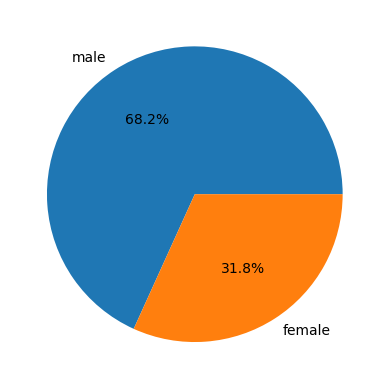

In [72]:
#2 觀察資料統計分布 - 不同性別的比例
# 統計男女數量、類別名稱和數量
sex_counts = df_data['sex'].value_counts()
sex_names = sex_counts.index.tolist()
sex_values = sex_counts.values.tolist()

# 繪製圓餅圖
plt.pie(sex_counts, autopct='%.1f%%', labels = ["male", "female"])
plt.show()

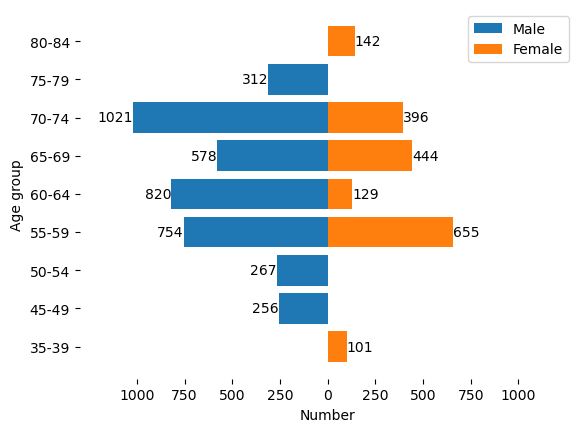

In [74]:
#3 觀察資料統計分布 - 不同性別間的年齡分布
# 設定範圍和標籤
age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, float('inf')]
age_labels = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49",
              "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", "80-84", "85-89", "90+"]

# 把年齡資料分組加到Dataframe
df_data['age_group'] = pd.cut(df_data['age'], bins=age_bins, labels=age_labels)

# 分組統計
df_population = df_data.groupby(['age_group', 'sex'], observed=False).size().unstack()

# 重製index
df_population = df_population.reset_index()

# 清除兩列都為0的資料
df_population = df_population[(df_population[0] != 0) | (df_population[1] != 0)]

# 計算資料
x_male = df_population[0] * -1
x_female = df_population[1]
y = df_population['age_group']

# 繪製圖形
fig, ax = plt.subplots()
ax1 = ax.barh(y, x_male, label = 'Male')
ax2 = ax.barh(y, x_female, label = 'Female')

ax.bar_label(ax1, labels=[f'{int(x)}' if x != 0 else '' for x in -ax1.datavalues])
ax.bar_label(ax2, labels=[f'{x}' if x != 0 else '' for x in ax2.datavalues])

ax.set_frame_on(False)

ax.set_xlim(-1300, 1300)
ax.set_xticks([-1000, -750, -500, -250, 0, 250, 500, 750, 1000])
ax.set_xticklabels([1000, 750, 500, 250, 0, 250, 500, 750, 1000])

ax.set_xlabel('Number')
ax.set_ylabel('Age group')

ax.legend()
plt.show()

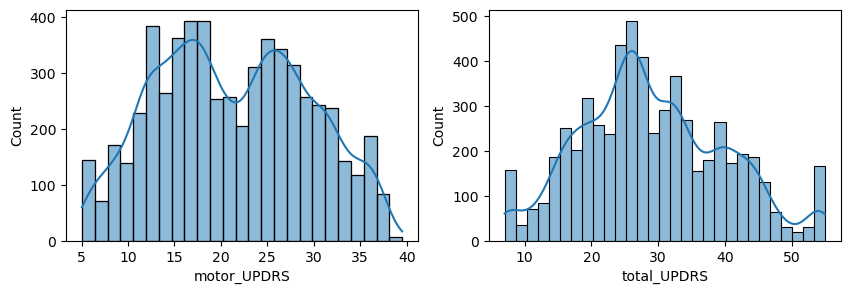

In [76]:
#4 觀察資料統計分布 - 輸出特徵分布
# 定義資料名稱串列
x_feature_names = ['motor_UPDRS', 'total_UPDRS']

# 繪製直方圖
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for ax, name in zip(axes.flatten(), x_feature_names):
    sns.histplot(data=df_data, x=name, kde=True, ax=ax)

結果可以發現：
- 男生的比例比較高
- 主要分布在70-74（男）和55-59（女）
- 輸出特徵的分布分別為雙峰和單峰

### 分割資料集

接著將資料集以測試3訓練7分割

In [79]:
#5 分割資料
# 提取輸入特徵、輸出名稱
x_feature_names = ['age', 'sex', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 
                   'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
y_target_names = ['motor_UPDRS', 'total_UPDRS']

# 提取輸入特徵、輸出資料
X = df_data[x_feature_names].values
y = df_data[y_target_names].values

# 以測試3訓練7分割資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Shape of training set X:', X_train.shape)
print('Shape of testing set X:', X_test.shape)

Shape of training set X: (4112, 19)
Shape of testing set X: (1763, 19)


### 建立模型

同樣使用貝氏搜尋尋找最佳超參數並建立模型

In [84]:
#6 建立迴歸決策樹模型
from sklearn.ensemble import RandomForestRegressor

# 設定模型
rf_reg = RandomForestRegressor(random_state=42)

# 定義搜尋空間
search_spaces = {'n_estimators': Integer(50, 300),
                 'max_depth': Integer(3, 20),
                 'min_samples_split': Integer(2, 20),
                 'min_samples_leaf': Integer(1, 10),
                 'max_features': Categorical(['sqrt', 'log2', None])}

# 貝氏搜尋優化器
opt = BayesSearchCV(estimator=rf_reg,
                    search_spaces=search_spaces,
                    scoring='neg_mean_squared_error',
                    cv=5,
                    n_iter=20,
                    n_jobs=-1,
                    verbose=1,
                    random_state=42)

# 搜尋並訓練模型
opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\USER\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [15, None, 1, 2, 300] before, using random point [12, None, 10, 10, 104]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_iter=20,
              n_jobs=-1, random_state=42, scoring='neg_mean_squared_error',
              search_spaces={'max_depth': Integer(low=3, high=20, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2', None), prior=None),
                             'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=300, prior='uniform', transform='normalize')},
              verbose=1)

### 評估訓練結果

查看MSE和R2 score，評估訓練結果

In [89]:
#7 評估訓練結果
from sklearn.metrics import r2_score, mean_squared_error

best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best parameters:", opt.best_params_)
print(f"Test MSE: {mse:.2f}")
print(f"Test R²: {r2:.4f}")

Best parameters: OrderedDict({'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 244})
Test MSE: 2.39
Test R²: 0.9731


結果可以發現：
- 這次資料比較多，所以最大深度比較深
- R2 score接近1，結果很準確

C:\Users\USER\AppData\Local\Temp\ipykernel_95856\1982676929.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(x_feature_names)[indices], palette='viridis')


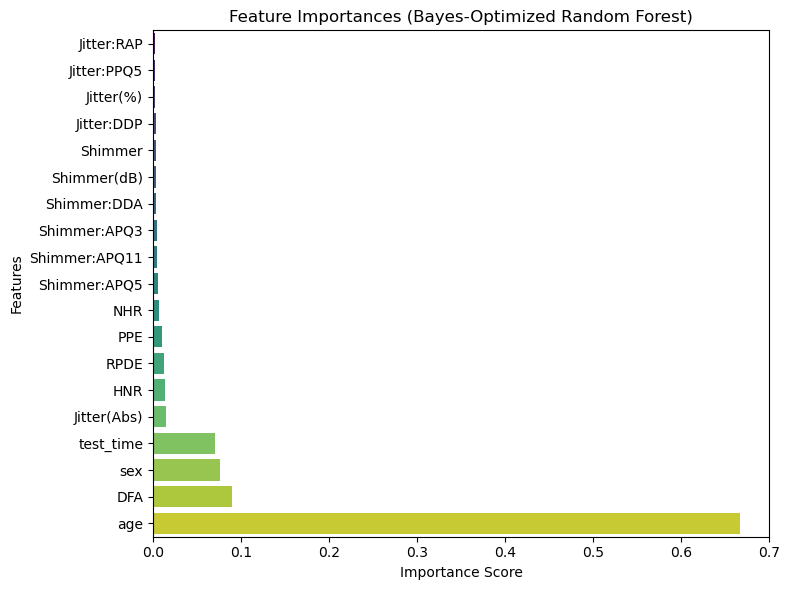

In [94]:
#8 特徵重要性分析
# 取得特徵重要性
best_model = opt.best_estimator_
importances = best_model.feature_importances_
indices = np.argsort(importances)

# 繪製橫向長條圖
plt.figure(figsize=(8, 6))
sns.barplot(x=importances[indices], y=np.array(x_feature_names)[indices], palette='viridis')
plt.title("Feature Importances (Bayes-Optimized Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

結果可以發現：
- 相較於其他決策因素，年齡有壓倒性優勢，可以說在帕金森氏症中，年齡可能是影響病情的主因之一

### **Part 3 XGBoost分類實作：銀行客戶定存申辦預測**

這次利用XGBoost預測銀行客戶是否會申辦定存，深入理解XGBoost在解決實際分類問題上的強大，並學習如何在金融領域應用XGBoost以提升預測準確度  
資料來源：https://archive.ics.uci.edu/dataset/222/bank+marketing

總共有45211筆資料，每筆資料都包含17個欄位，記錄了客戶的詳細資訊

輸入特徵：
- age（數值型）：年齡
- job（類別型）：職業
  - admin 管理員
  - blue-collar 藍領
  - entrepreneur 企業家
  - housemaid 保母
  - management 經理
  - retired 已退休
  - self-employed 自顧
  - services 服務業
  - student 學生
  - technician 技術員
  - unemployed 待業
  - unknown 未知
- marital（類別型）：婚姻狀況
  - divorced 離婚
  - married 已婚
  - single 單身
- education（類別型）：教育背景
  - primary 國小
  - secondary 國中
  - tertiary 高中以上
  - unknown 未知
- default（類別型）：是否有信用卡違約紀錄
  - no 否
  - yes 是
  - unknown 未知
- balance（數值型）：帳戶餘額
- housing（類別型）：是否有住房貸款
  - no 否
  - yes 是
  - unknown 未知
- loan（類別型）：是否有個人貸款
  - no 否
  - yes 是
  - unknown 未知
- contact（類別型）：聯繫方式
  - cellular 行動電話
  - telephone 市內電話
  - unknown 未知
- day（數值型）：最後一次聯繫日
- month（類別型）：最後一次聯繫月份
- duration（數值型）：聯繫持續時間（秒）
- campaign（數值型）：此次行銷活動中與客戶聯繫的次數
- pdays（數值型）：距離上次聯繫的天數
- previous（數值型）：上次行銷活動中與客戶聯繫的天數
- poutcome（類別型）：之前行銷活動的結果
  - failure 失敗
  - unknown 無紀錄
  - success 成功
  - other 其他

輸出：
- deposit（類別型）：此客戶最後是否辦理定存
  - yes 是
  - no 否

In [154]:
#1 載入資料集
df = pd.read_csv('./dataset/bank_marketing/bank/bank_full_fixed.csv')

### 資料視覺化

分別觀察並分析數值型與類別型特徵的統計分布情形

In [157]:
#2 提取特徵名稱
# 數值型
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()

# 類別型
categorical_columns = df.select_dtypes(include='object').columns.tolist()

print("Numerical: ", numerical_columns)
print("Categorical: ", categorical_columns)

Numerical:  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


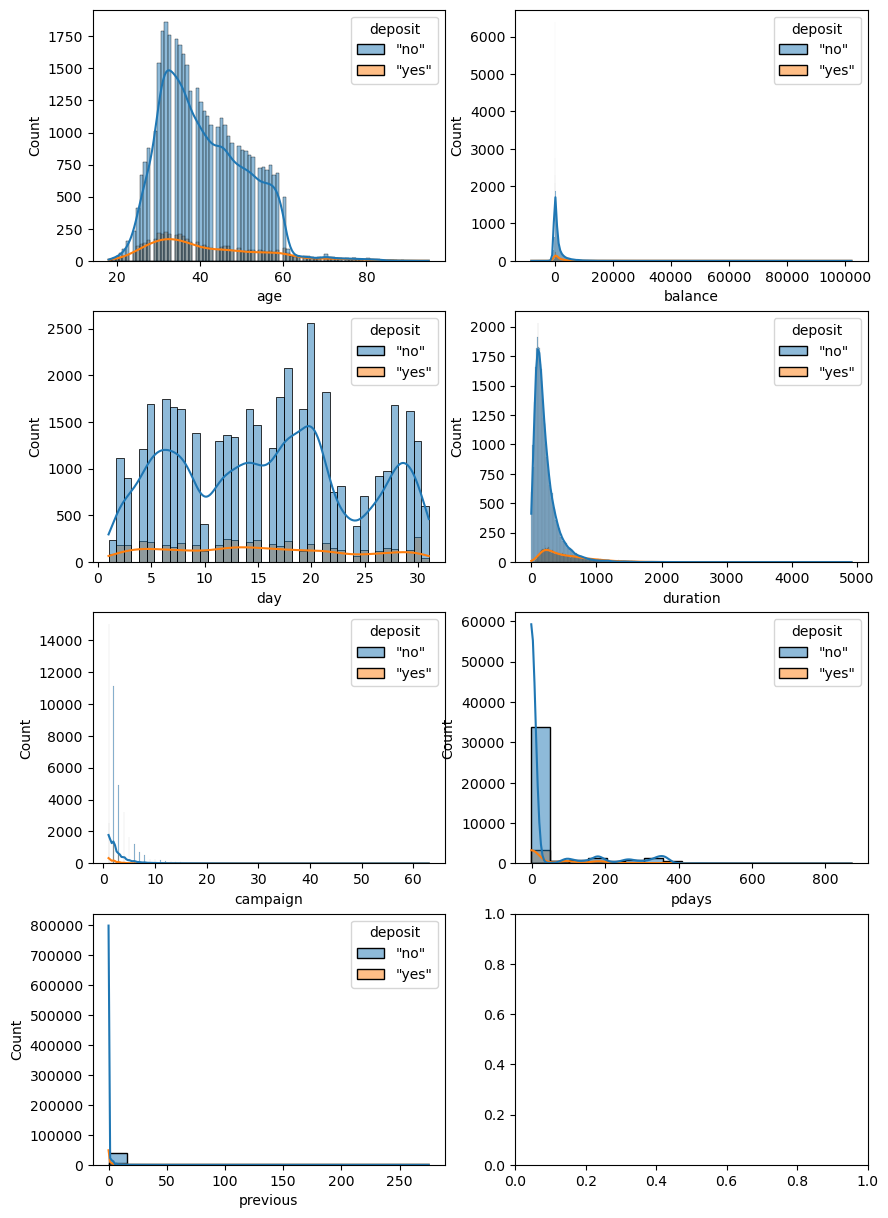

In [159]:
#3 分析數值型特徵統計分布
# 繪製直方圖
fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for ax, name in zip(axes.flatten(), numerical_columns):
    sns.histplot(data=df, x=name, hue="deposit", kde=True, palette="tab10", ax=ax)

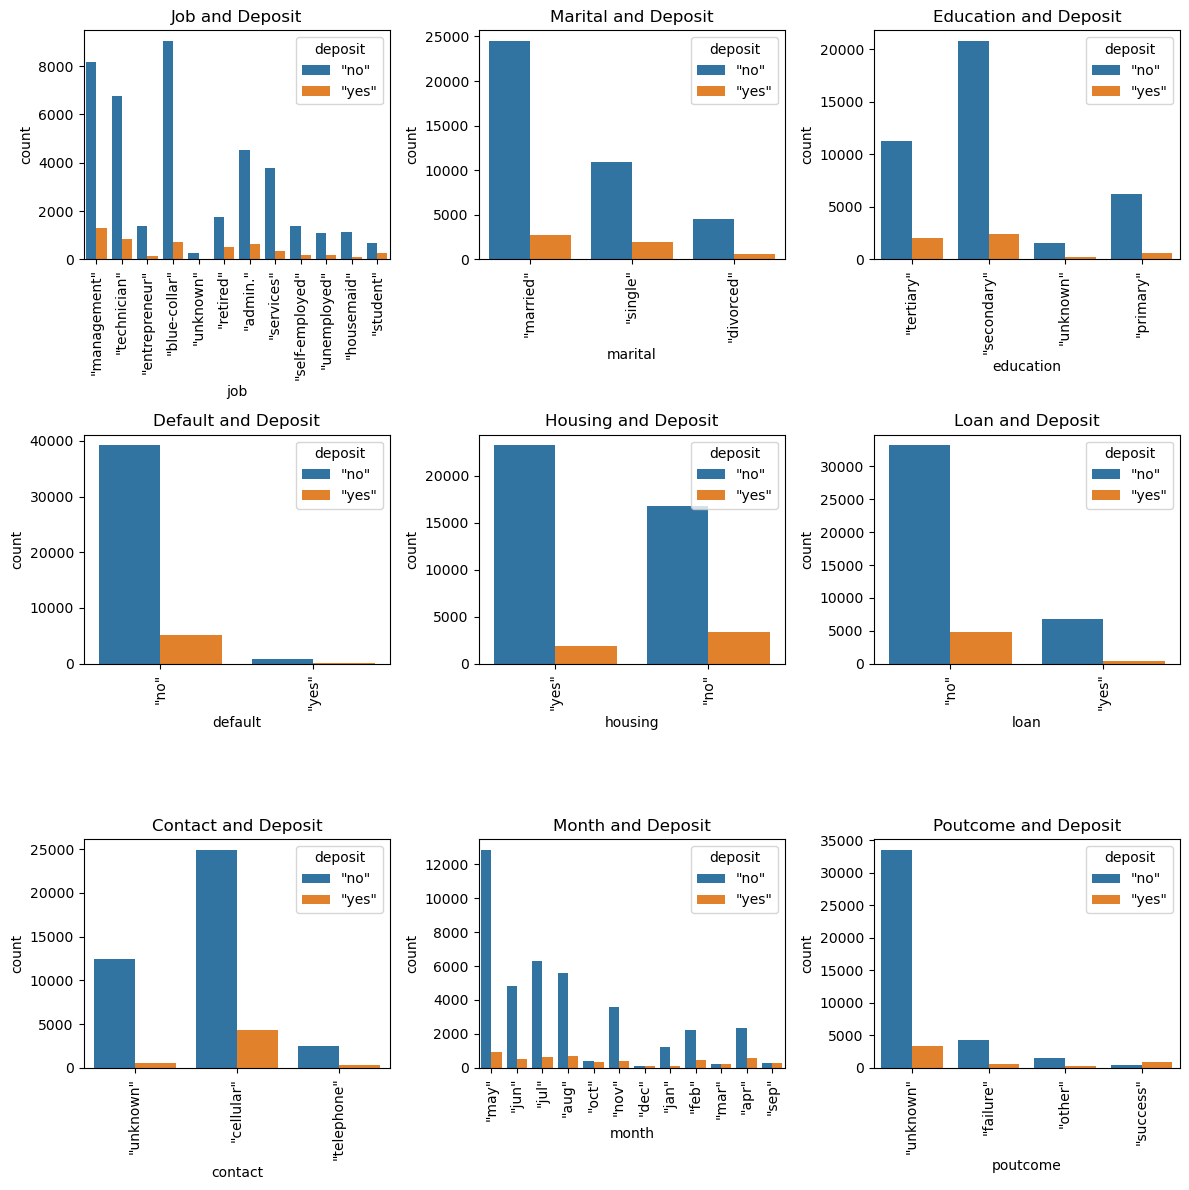

In [160]:
#4 分析類別型特徵統計分布
# 繪製直方圖
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for ax, name in zip(axes.flatten(), categorical_columns):
    sns.countplot(data=df, x=name, hue="deposit", palette="tab10", ax=ax)
    ax.set_title(f'{name.capitalize()} and Deposit')
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

結果可以發現：
- 多數數值型特徵有很嚴重的偏差（尤其是balance, duration, campaign, pdays, previous），可能需要轉換或特別處理
- deposit為no的還是多很多，大多數的資料分布都有明顯差異（幾乎都存在絕對多數）

### 資料前處理

進行類別轉換，編碼並處理資料不平衡的問題

In [163]:
#5 資料前處理 - 類別轉換
# 去掉雙引號
df['deposit'] = df['deposit'].str.replace('"', '')

# 編碼（ yes = 1, no = 0 ）
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})

# 確認結果
print(df['deposit'].value_counts())

deposit
0    39922
1     5289
Name: count, dtype: int64


In [167]:
#6 資料前處理 - 類別編碼、平衡
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# 分離特徵與標籤
X = df.drop(columns='deposit')
y = df['deposit']

# 把類別型和數值型欄位分開
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include='number').columns.tolist()

# 建立前處理器
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
                                 remainder='passthrough')

# 處理不平衡類別比例
neg, pos = (y == 0).sum(), (y == 1).sum()
scale_pos_weight = round(neg / pos, 2)

### 分割資料集

將資料集以測試3訓練7的比例切割

In [172]:
#7 分割資料
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

### 建立模型

設定模型、pipeline並使用貝氏搜尋建立模型

In [180]:
#8 建立模型
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# 建立模型
xgb_model = XGBClassifier(eval_metric='logloss',
                          scale_pos_weight=scale_pos_weight,
                          random_state=42,
                          n_jobs=-1)

# 建立Pipeline
pipeline = Pipeline([('preprocessor', preprocessor),
                     ('xgb', xgb_model)])

# 超參數搜尋範圍
search_spaces = {'xgb__n_estimators': Integer(50, 300),
                 'xgb__max_depth': Integer(3, 12),
                 'xgb__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                 'xgb__subsample': Real(0.6, 1.0),
                 'xgb__colsample_bytree': Real(0.6, 1.0)}

# 建立搜尋模型
opt = BayesSearchCV(estimator=pipeline,
                    search_spaces=search_spaces,
                    scoring='accuracy',
                    cv=5,
                    n_iter=20,
                    verbose=1,
                    n_jobs=-1,
                    random_state=42)

# 訓練模型
opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('cat',
                                                                          OneHotEncoder(handle_unknown='ignore'),
                                                                          ['job',
                                                                           'marital',
                                                                           'education',
                                                                           'default',
                                                                           'housing',
                                                                           'loan',
                                                                           'contact',
                                                                           'month',
                                                                           'poutcome'])])),
                                        ('xgb',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample...
              search_spaces={'xgb__colsample_bytree': Real(low=0.6, high=1.0, prior='uniform', transform='normalize'),
                             'xgb__learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='normalize'),
                             'xgb__max_depth': Integer(low=3, high=12, prior='uniform', transform='normalize'),
                             'xgb__n_estimators': Integer(low=50, high=300, prior='uniform', transform='normalize'),
                             'xgb__subsample': Real(low=0.6, high=1.0, prior='uniform', transform='normalize')},
              verbose=1)

### 評估模型訓練結果

查看各項模型準確度評估數據

In [183]:
#9 評估模型結果
# 用模型預測
y_pred = opt.predict(X_test)

# 輸出結果
print("Best parameters:", opt.best_params_)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best parameters: OrderedDict({'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.12771292851524904, 'xgb__max_depth': 12, 'xgb__n_estimators': 224, 'xgb__subsample': 1.0})
Test Accuracy: 0.9019

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94     11977
           1       0.57      0.62      0.60      1587

    accuracy                           0.90     13564
   macro avg       0.76      0.78      0.77     13564
weighted avg       0.91      0.90      0.90     13564



結果可以發現：
- 雖然整體準確度很高，但很明顯類別1的部分特別不準
- 類別1的recall高，對實用上來說是一個比較好的結果

### **Part 4 XGBoost迴歸實作：汽車燃油效率預測**

這次利用XGBoost進行迴歸分析，用飲琴大小、車重、氣缸數等等的特徵預測汽車的燃油效率，  
資料來源：https://archive.ics.uci.edu/dataset/9/auto+mpg

總共有398筆資料，每筆資料都包含7個車子相關的資訊

輸入特徵：
- cylinders：引擎氣缸數
- displacement：引擎總排氣量（in$^3$）
- horsepower：引擎馬力（hp）
- weight：車重（lb）
- acceleration：0-60mile所需秒數（sec）
- model year：車型年份
- origin：產地（1：美國，2：歐洲，3：日本）
- car name：車名

輸出：
- mpg（Miles Per Gallon）：燃油效率

In [218]:
#1 載入資料集
column_names = ["mpg", "cylinders", "displacement", "horsepower", "weight",
                "acceleration", "model_year", "origin", "car_name"]

df = pd.read_csv("./Dataset/auto_mpg/auto_mpg.data", sep=r'\s+', names=column_names, na_values="?")
df.info()

# 資料清洗
df.dropna(inplace=True)

# 提取X, y
X = df[["cylinders", "displacement", "horsepower", "weight",
        "acceleration", "model_year", "origin"]]
y = df["mpg"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


### 資料視覺化

以不同視角觀察資料的分布狀況

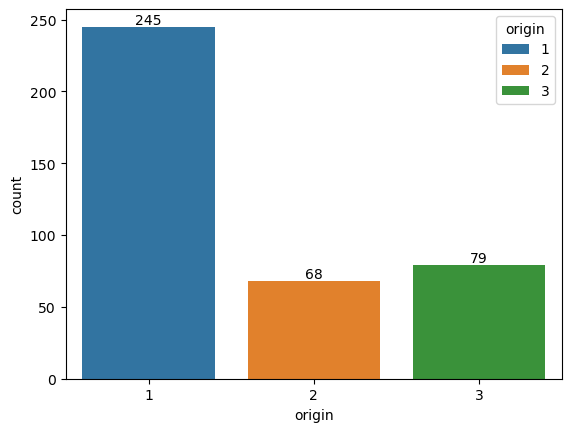

In [220]:
#2 觀察資料統計分布 - 以地區為主
# 繪製直方圖
ax = sns.countplot(data=df, x = 'origin', hue = 'origin', palette = 'tab10')
for container in ax.containers:
    ax.bar_label(container)

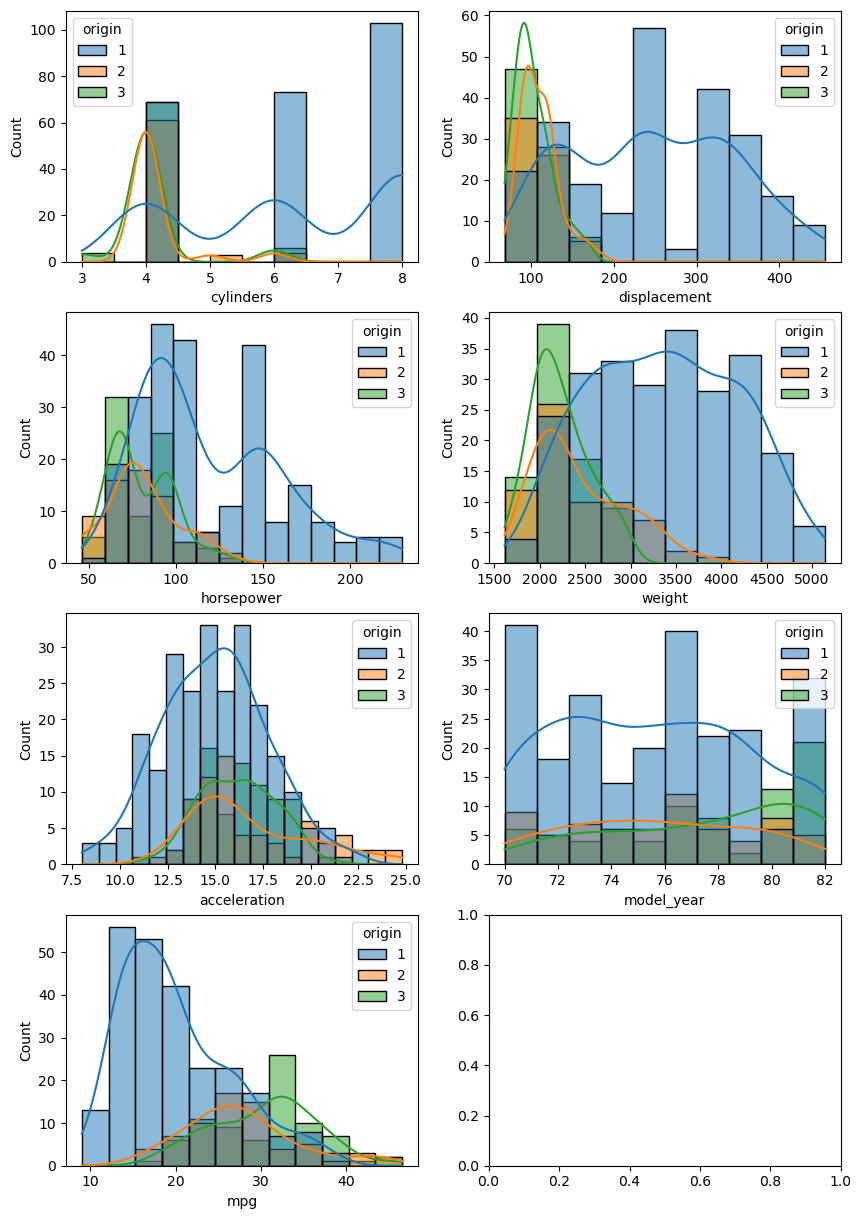

In [222]:
#3 觀察資料統計分布 - 其他特徵
x_feature_names = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'mpg']

# 繪製直方圖
fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for ax, name in zip(axes.flatten(), x_feature_names):
    sns.histplot(data=df, x=name, hue="origin", kde=True, palette="tab10", ax=ax)

<Axes: >

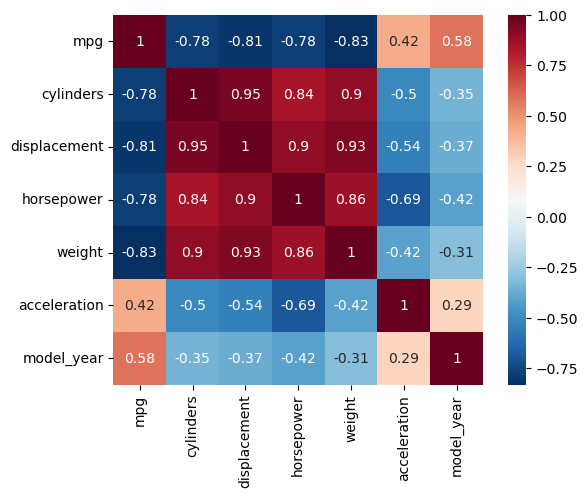

In [224]:
#4 繪製相關性熱圖
# 計算相關性矩陣
corr = df[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']].corr()

sns.heatmap(corr, square=True, annot=True, cmap="RdBu_r")

結果可發現：
- 在cylinder, displacement weight, mpg上不同國家的車有較顯著的差異  
- mpg和cylinders, displacement, horsepower, weight之間呈負相關，說明車輛越重、排氣量越大、馬力越強，燃油效率就越低  
- mpg和model_year呈正相關，說明新車的燃油效率較高

### 分割資料集

以測試3訓練7分割資料

In [226]:
#5 分割資料
# 提取輸入特徵和輸出
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Shape of training set X:', X_train.shape)
print('Shape of testing set X:', X_test.shape)

Shape of training set X: (274, 7)
Shape of testing set X: (118, 7)


### 資料預處理

對數值型資料進行預處理

In [233]:
#6 資料預處理
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                              ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, X.columns)])

### 建立模型

同樣用貝氏搜尋並建立模型

In [235]:
#7 建立XGBoost迴歸模型
from xgboost import XGBRegressor

# 建立Pipeline
pipeline = Pipeline([('preprocessor', preprocessor),
                     ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))])

# 設定搜尋空間
search_space = {'xgb__n_estimators': Integer(50, 300),
               'xgb__max_depth': Integer(3, 15),
               'xgb__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
               'xgb__subsample': Real(0.5, 1.0),
               'xgb__colsample_bytree': Real(0.5, 1.0)}

# 建立搜尋模型
opt = BayesSearchCV(estimator=pipeline,
                    search_spaces=search_space,
                    n_iter=20,
                    cv=5,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=1,
                    random_state=42)

# 訓練模型
opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer()),
                                                                                          ('scaler',
                                                                                           StandardScaler())]),
                                                                          Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model_year', 'origin'],
      dtype='object'))])),
                                        ('xgb',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=Non...
              search_spaces={'xgb__colsample_bytree': Real(low=0.5, high=1.0, prior='uniform', transform='normalize'),
                             'xgb__learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='normalize'),
                             'xgb__max_depth': Integer(low=3, high=15, prior='uniform', transform='normalize'),
                             'xgb__n_estimators': Integer(low=50, high=300, prior='uniform', transform='normalize'),
                             'xgb__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=1)

### 評估訓練結果

用模型數據評估訓練結果

In [238]:
#8 評估訓練結果

print("Best parameters:", opt.best_params_)
print("Test RMSE:", np.sqrt(-opt.score(X_test, y_test)))

Best parameters: OrderedDict({'xgb__colsample_bytree': 0.6578507889744729, 'xgb__learning_rate': 0.11865970676422036, 'xgb__max_depth': 3, 'xgb__n_estimators': 285, 'xgb__subsample': 0.8420265087755918})
Test RMSE: 2.9915375997779456


結果可以發現：
- RMSE = 2.99，結果還可以